# Batch analysis across mice & regions

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Parameters

In [3]:
# Mouse line
mouseline = 'line3'
peak_correction_quantile = PEAK_CORRECTION_QUANTILE

### Load data

In [16]:
dataroot = get_data_root()
data_dir = os.path.join(dataroot, mouseline)
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
processed_dir = get_output_equivalent(data_dir, 'raw', 'processed')
trialavg_dir = get_output_equivalent(data_dir, 'raw', 'trial-averaged')
trialavg_dir = os.path.join(trialavg_dir, f'q{peak_correction_quantile * 1e2:.0f}')
logger.info(f'loading data from {trialavg_dir}:')
data = load_mousereg_datasets(trialavg_dir)
timeseries = data['timeseries']
stats = data['stats']
stats

 16/05/2022 17:46:21: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/line3/q30:
 16/05/2022 17:46:21: loading timeseries data from timeseries_mouse1_region1.csv
 16/05/2022 17:46:22: loading timeseries data from timeseries_mouse1_region2.csv
 16/05/2022 17:46:22: loading timeseries data from timeseries_mouse6_region1.csv
 16/05/2022 17:46:23: loading timeseries data from timeseries_mouse6_region2.csv
 16/05/2022 17:46:23: loading timeseries data from timeseries_mouse7_region1.csv
 16/05/2022 17:46:24: loading timeseries data from timeseries_mouse7_region2.csv
 16/05/2022 17:46:25: loading timeseries data from timeseries_mouse9_region1.csv
 16/05/2022 17:46:26: loading timeseries data from timeseries_mouse9_region2.csv
 16/05/2022 17:46:26: loading timeseries data from timeseries_mouse10_region1.csv
 16/05/2022 17:46:26: loading timeseries data from timeseries_mouse12_region1.csv
 16/05/2022 17:46:28: loading stats data from stats_mouse1_region1.csv
 16/05/2022 17:

line  trial_length  duration (s)   fps  P (MPa)  \
mouse_reg       ROI run                                                     
mouse10_region1 0   0    line3         100.0           0.2  3.56     0.00   
                    1    line3         100.0           0.2  3.56     0.10   
                    2    line3         100.0           0.2  3.56     0.20   
                    3    line3         100.0           0.2  3.56     0.40   
                    4    line3         100.0           0.2  3.56     0.05   
...                        ...           ...           ...   ...      ...   
mouse9_region2  690 10   line3         100.0           0.2  3.56     0.80   
                    11   line3         100.0           0.2  3.56     0.80   
                    12   line3         100.0           0.2  3.56     0.80   
                    13   line3         100.0           0.2  3.56     0.80   
                    14   line3         100.0           0.2  3.56     0.80   

                         DC (%)  run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
mouse_reg       ROI run                                                   
mouse10_region1 0   0      50.0   833.0        0.000000        0.000000   
                    1      50.0   831.0        0.309132        0.154566   
                    2      50.0   830.0        1.236530        0.618265   
                    3      50.0   829.0        4.946119        2.473059   
                    4      50.0   832.0        0.077283        0.038642   
...                         ...     ...             ...             ...   
mouse9_region2  690 10     40.0   903.0       19.784475        7.913790   
                    11     50.0   902.0       19.784475        9.892238   
                    12     60.0   908.0       19.784475       11.870685   
                    13     70.0   909.0       19.784475       13.849133   
                    14     80.0   910.0       19.784475       15.827580   

                         max pre-stim Z(ΔF/F0)  peak Z(ΔF/F0)  \
mouse_reg       ROI run                                         
mouse10_region1 0   0                 0.152391       0.237306   
                    1                 0.583637      11.244186   
                    2                 0.301746       3.708657   
                    3                 0.261982       4.411709   
                    4                 0.267697       2.749216   
...                                        ...            ...   
mouse9_region2  690 10                0.526445       0.305145   
                    11                0.383755       0.984543   
                    12                0.376397       0.374894   
                    13                0.479559       1.350741   
                    14                0.597379       2.202096   

                         baseline peak Z(ΔF/F0)  corrected peak Z(ΔF/F0)  \
mouse_reg       ROI run                                                    
mouse10_region1 0   0                  2.157014                -1.919708   
                    1                  4.315899                 6.928287   
                    2                  5.423915                -1.715258   
                    3                  1.576403                 2.835305   
                    4                  3.612272                -0.863056   
...                                         ...                      ...   
mouse9_region2  690 10                 0.610020                -0.304875   
                    11                 0.653655                 0.330888   
                    12                 0.707753                -0.332859   
                    13                 0.558442                 0.792299   
                    14                 0.651207                 1.550889   

                         positive condition?  # positive conditions  \
mouse_reg       ROI run                                               
mouse10_region1 0   0                  False                      5   


### Breakdown per mouse region

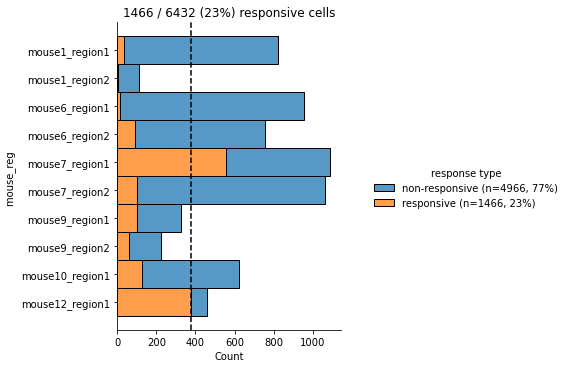

In [17]:
# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = MIN_CELL_DENSITY * area
# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count)

### Exclude datasets with low cell count

 16/05/2022 17:46:36: excluding ['mouse9_region2', 'mouse1_region2', 'mouse9_region1'] datasets from analysis


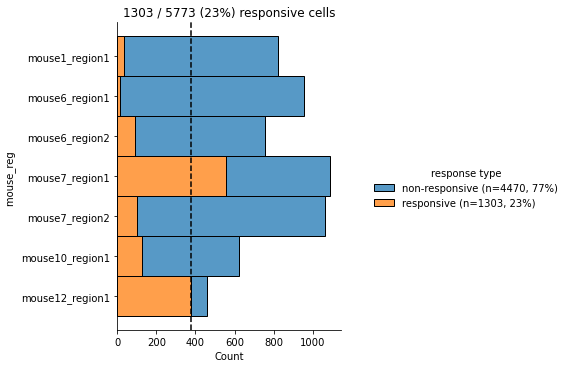

In [18]:
# Idendify datasets with a low overall cell count
celltypes = stats.groupby([Label.MOUSEREG, Label.ROI]).first()
cellcounts = celltypes.groupby(Label.MOUSEREG).count().iloc[:, 0].rename('counts')
to_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()

# Exclude them
data = exclude_datasets(data.copy(), to_exclude)
timeseries = data['timeseries']
stats = data['stats']
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count)

In [26]:
# Extract stimulus-evoked peak
stats[f'peak {Label.DFF}'] = apply_in_window(
    find_max, timeseries.copy(), Label.DFF, FrameIndex.RESPONSE)

 16/05/2022 17:50:12: applying find_max function on ΔF/F0 in 10-20 index window across mouse_reg, ROI, run ...
 16/05/2022 17:50:16: identified outputs in 86594/86594 windows (100.0 %)


/var/folders/86/b3z067_j0sbfgbhl7gx4p5640000gn/T/ipykernel_45794/892851420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats[f'peak {Label.DFF}'] = apply_in_window(


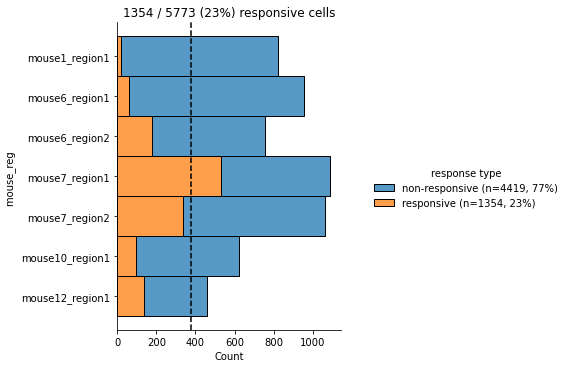

In [32]:
fig = plot_cellcounts_by_type(
    reclassify(
        stats.copy(),
        ykey=f'peak {Label.DFF}',
        ythr=.2),#pvalue_to_zscore(PTHR_DETECTION)),
    hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count)

## Parameter dependency curves

### Plotting function

In [38]:
def plot_paramsdeps(stats, ykey_peak, stimparams=[Label.P, Label.DC], ythr=None, nposthr=None, weighted=False, **kwargs):
    if Label.ZSCORE in ykey_peak:
        ykey = Label.ZSCORE
    elif Label.DFF in ykey_peak:
        ykey = Label.DFF
    else:
        raise ValueError(f'unknown y key: {ykey_peak}')

    # Determine variable of interest for output metrics
    if ythr is None:
        ythr = {Label.ZSCORE: pvalue_to_zscore(PTHR_DETECTION), Label.DFF: .1}[ykey]

    # Re-classify stats according to new criterion, if specified
    if ythr is not None or nposthr is not None:
        stats = reclassify(stats.copy(), ykey_peak, ythr=ythr, nposthr=nposthr)

    # Determine plot parameters
    if not is_iterable(stimparams):
        stimparams = [stimparams]
    weighted = [True, False] if weighted == 'both' else [weighted]
    ybounds = {Label.ZSCORE: (-.5, 4.5), Label.DFF: None}[ykey]
    
    # For each stimulus parameters 
    for xkey in stimparams:
        # For each weighting type
        for w in weighted:
            wstr = {True: '', False: 'non-'}[w] + 'weighted'
            # Plot parameter dependency across cell types
            fig = plot_parameter_dependency_across_datasets(
                stats, xkey, ykey_peak, weighted=w,
                baseline=[0., ythr], ybounds=ybounds, height=4, aspect=1., 
                hide_col_prefix=True, col_count_key=[Label.MOUSEREG, Label.ROI],
                **kwargs)
            # Add re-classification info to title
            suffix = []
            if nposthr is not None:
                suffix.append(f'nposthr = {nposthr}')
            if ythr is not None:
                suffix.append(f'ythr = {ythr:.2f}')
            if len(suffix) > 0:
                ttl = fig._suptitle.get_text()
                fig.suptitle(f'{ttl} [{", ".join(suffix)}]')
            # Add figure to figures dictionary
            figs[f'{ykey_peak} vs {xkey} {wstr}'] = fig

### corrected vs uncorrected peak Z(ΔF/F)

 16/05/2022 17:59:57: sub-indexing data...
 16/05/2022 17:59:57: filtering data...
 16/05/2022 17:59:57: cross-checking filters...
 16/05/2022 17:59:57: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 16/05/2022 17:59:58: sub-indexing data...
 16/05/2022 17:59:58: filtering data...
 16/05/2022 17:59:58: cross-checking filters...
 16/05/2022 17:59:58: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. DC (%) ...
 16/05/2022 18:00:00: sub-indexing data...
 16/05/2022 18:00:00: filtering data...
 16/05/2022 18:00:00: cross-checking filters...
 16/05/2022 18:00:00: grouping by response type, grouping by mouse_reg, averaging and plotting mean peak Z(ΔF/F0) vs. P (MPa) ...
 16/05/2022 18:00:00: sub-indexing data...
 16/05/2022 18:00:00: filtering data...
 16/05/2022 18:00:00: cross-checking filters...
 16/05/2022 18:00:01: grouping by response type, grouping by mouse_

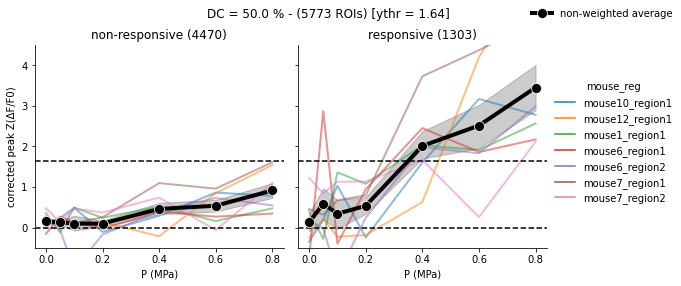

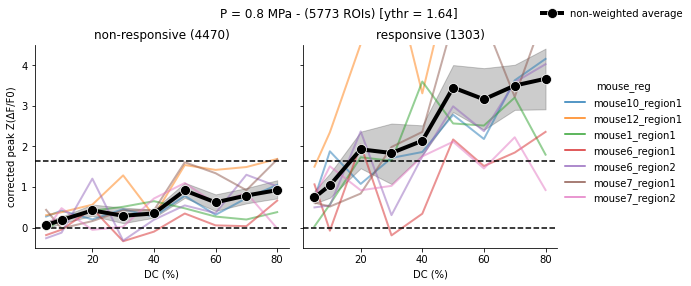

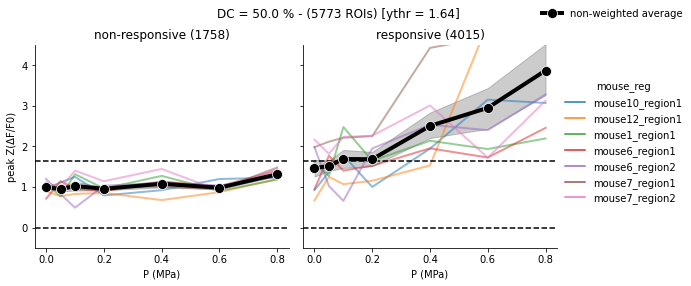

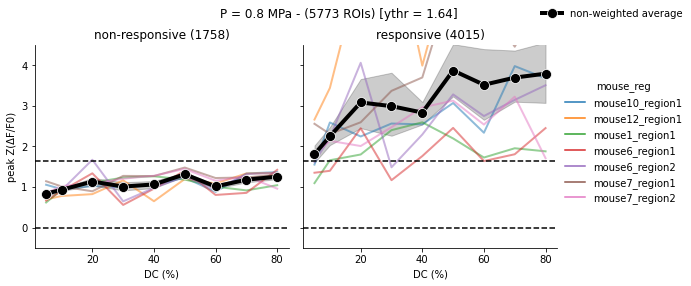

In [40]:
for k in ['corrected ', '']:
    plot_paramsdeps(stats, f'{k}peak {Label.ZSCORE}', show_datasets=True)

### Influence of detection threshold

 16/05/2022 18:21:02: sub-indexing data...
 16/05/2022 18:21:02: filtering data...
 16/05/2022 18:21:02: cross-checking filters...
 16/05/2022 18:21:02: grouping by response type, grouping by mouse_reg, averaging and plotting mean peak Z(ΔF/F0) vs. P (MPa) ...
 16/05/2022 18:21:03: sub-indexing data...
 16/05/2022 18:21:03: filtering data...
 16/05/2022 18:21:03: cross-checking filters...
 16/05/2022 18:21:03: grouping by response type, grouping by mouse_reg, averaging and plotting mean peak Z(ΔF/F0) vs. P (MPa) ...
 16/05/2022 18:21:04: sub-indexing data...
 16/05/2022 18:21:04: filtering data...
 16/05/2022 18:21:04: cross-checking filters...
 16/05/2022 18:21:04: grouping by response type, grouping by mouse_reg, averaging and plotting mean peak Z(ΔF/F0) vs. P (MPa) ...
 16/05/2022 18:21:05: sub-indexing data...
 16/05/2022 18:21:05: filtering data...
 16/05/2022 18:21:05: cross-checking filters...
 16/05/2022 18:21:05: grouping by response type, grouping by mouse_reg, averaging and 

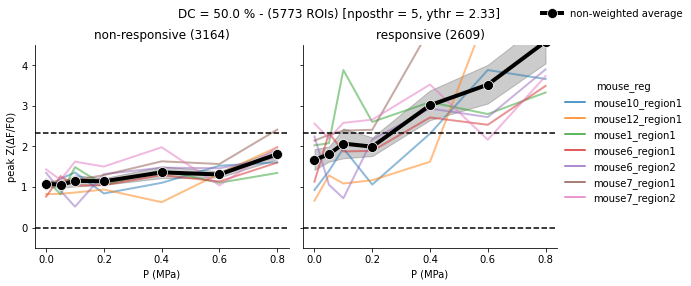

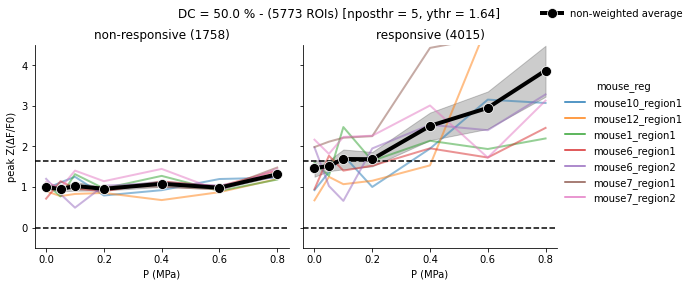

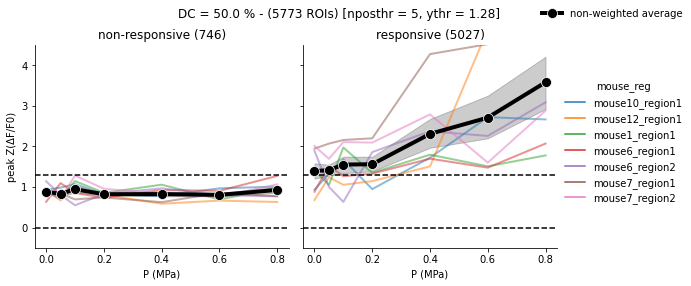

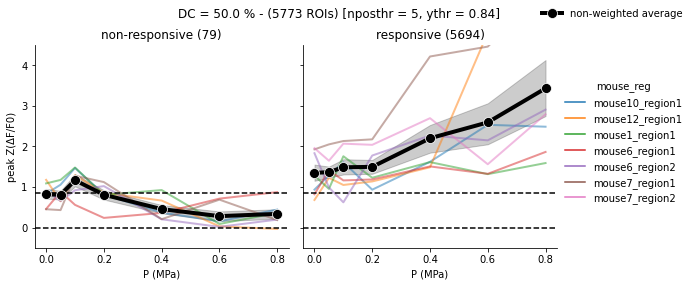

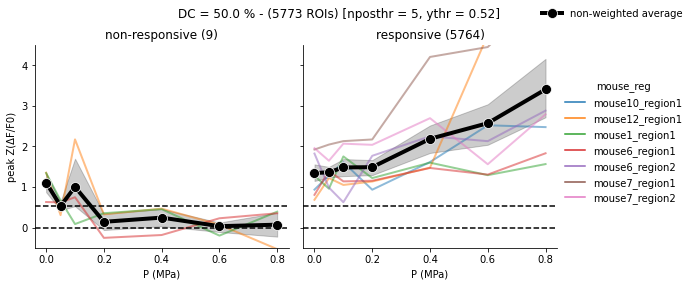

In [44]:
for pthr in [.01, .05, .1, .2, .3]:
    zthr = pvalue_to_zscore(pthr)
    plot_paramsdeps(
        stats, f'peak {Label.ZSCORE}', stimparams=Label.P, ythr=zthr, nposthr=5)

### Influence of threshold number of positive conditions

 16/05/2022 18:22:27: sub-indexing data...
 16/05/2022 18:22:27: filtering data...
 16/05/2022 18:22:27: cross-checking filters...
 16/05/2022 18:22:27: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 16/05/2022 18:22:28: sub-indexing data...
 16/05/2022 18:22:28: filtering data...
 16/05/2022 18:22:28: cross-checking filters...
 16/05/2022 18:22:28: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 16/05/2022 18:22:29: sub-indexing data...
 16/05/2022 18:22:29: filtering data...
 16/05/2022 18:22:29: cross-checking filters...
 16/05/2022 18:22:29: grouping by response type, grouping by mouse_reg, averaging and plotting mean corrected peak Z(ΔF/F0) vs. P (MPa) ...
 16/05/2022 18:22:30: sub-indexing data...
 16/05/2022 18:22:30: filtering data...
 16/05/2022 18:22:30: cross-checking filters...
 16/05/2022 18:22:30: grouping by response type, groupin

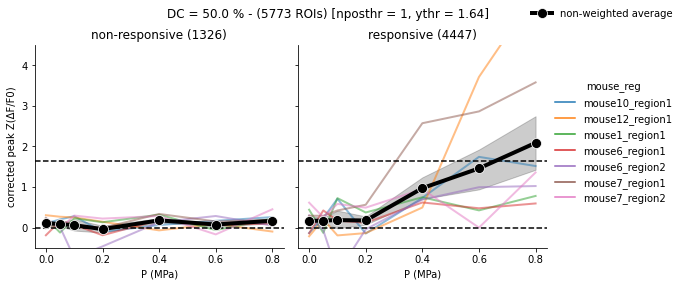

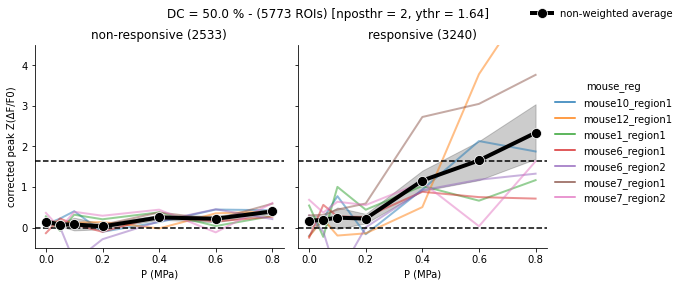

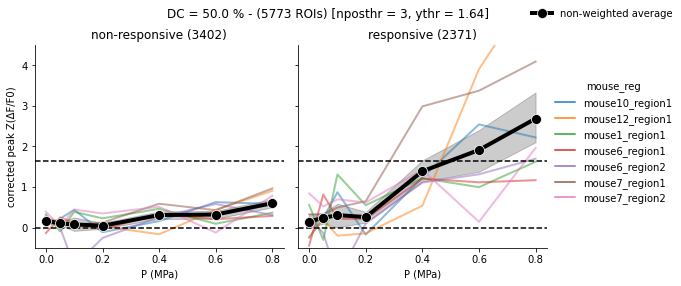

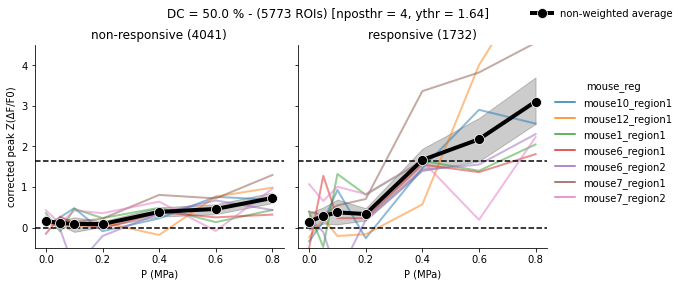

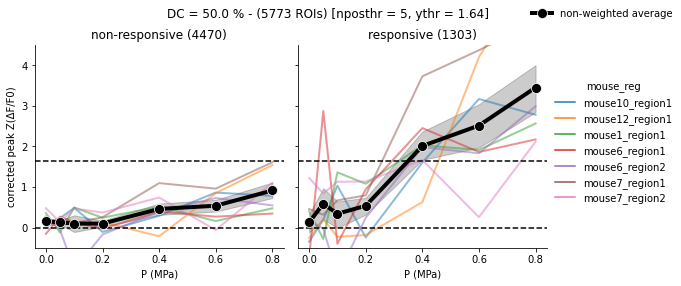

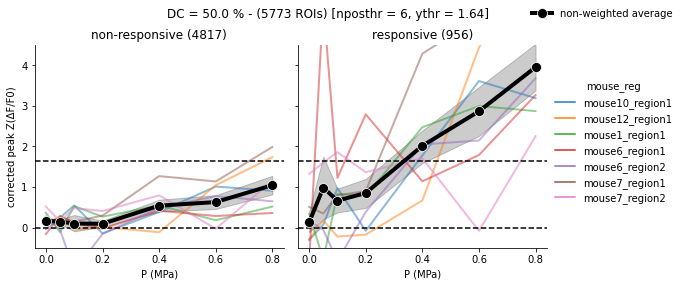

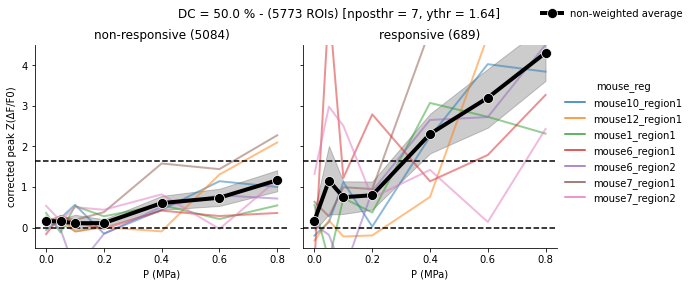

In [45]:
zthr = pvalue_to_zscore(PTHR_DETECTION)
for n in np.arange(7) + 1:
    plot_paramsdeps(
        stats, f'corrected peak {Label.ZSCORE}', stimparams=Label.P, ythr=zthr, nposthr=n)

## Traces

In [47]:
plt_data = get_plot_data(timeseries, stats)

 16/05/2022 18:23:56: merging timeseries and stats information...
 16/05/2022 18:24:25: adding time info to table...


In [46]:
ykey = Label.ZSCORE

tracekwargs = dict(
    tbounds = [-2, 8.],  # s
    ybounds = {
        Label.ZSCORE: [-1.5, 10.],
        Label.DFF: [0, .25]
        }[ykey],   # y-axis unit
    height = 4,  # height of each figure axis
    aspect = 0.7,  # width / height aspect ratio of each axis
)

for resptype, group in plt_data.groupby(Label.ROI_RESP_TYPE):
    logger.info(f'plotting dependency curves for {resptype} cells...')
    # Pressure dependency
    figs[f'responses {ykey} by type DC={DC_REF}%'] = plot_responses(
        group, ykey=ykey, DC=DC_REF, hue=Label.P, 
        col=Label.MOUSEREG, max_colwrap=3, **tracekwargs)
    # # Duty cycle dependency
    # figs[f'responses {ykey} by type P={P_REF}MPa'] = plot_responses(
    #     plt_data, ykey=ykey, P=P_REF, hue=Label.DC, 
    #     col=Label.ROI_RESP_TYPE, **tracekwargs)

NameError: name 'plt_data' is not defined

In [334]:
# Copy data and remove run index
avg_plt_data = plt_data.copy().droplevel(Label.RUN)
# Generate new run index from (P, DC) combination 
tmp1 = avg_plt_data[Label.P].map('{:.2f}MPa'.format)
tmp2 = avg_plt_data[Label.DC].map('{:.0f}%DC'.format)
avg_plt_data[Label.RUN] = tmp1 + tmp2
avg_plt_data.set_index(Label.RUN, append=True, inplace=True)
# Group data by mouse-region, response type, run and frame -> average
avg_plt_data = avg_plt_data.groupby(
    [Label.MOUSEREG, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR])

In [343]:
avg_plt_data2 = avg_plt_data.loc[:, [
    Label.P,
    Label.DC,
    Label.DUR,
    Label.TIME,
    Label.DFF,
    Label.ZSCORE
]]
avg_plt_data2

P (MPa)  DC (%)  \
mouse_reg       response type  run          frame                    
mouse10_region1 non-responsive 0.00MPa50%DC 0          0.0    50.0   
                                            1          0.0    50.0   
                                            2          0.0    50.0   
                                            3          0.0    50.0   
                                            4          0.0    50.0   
...                                                    ...     ...   
mouse7_region2  responsive     0.80MPa80%DC 95         0.8    80.0   
                                            96         0.8    80.0   
                                            97         0.8    80.0   
                                            98         0.8    80.0   
                                            99         0.8    80.0   

                                                   duration (s)   time (s)  \
mouse_reg       response type  run          frame                            
mouse10_region1 non-responsive 0.00MPa50%DC 0               0.2  -2.808989   
                                            1               0.2  -2.528090   
                                            2               0.2  -2.247191   
                                            3               0.2  -1.966292   
                                            4               0.2  -1.685393   
...                                                         ...        ...   
mouse7_region2  responsive     0.80MPa80%DC 95              0.2  23.876404   
                                            96              0.2  24.157303   
                                            97              0.2  24.438202   
                                            98              0.2  24.719101   
                                            99              0.2  25.000000   

                                                      ΔF/F0  Z(ΔF/F0)  
mouse_reg       response type  run          frame                      
mouse10_region1 non-responsive 0.00MPa50%DC 0      0.107019 -0.024015  
                                            1      0.115102  0.088903  
                                            2      0.122544  0.189725  
                                            3      0.121021  0.174803  
                                            4      0.116640  0.121139  
...                                                     ...       ...  
mouse7_region2  responsive     0.80MPa80%DC 95     0.164610  0.638125  
                                            96     0.165785  0.651761  
                                            97     0.163756  0.623942  
                                            98     0.160542  0.595325  
                                            99     0.157392  0.556107  

[21000 rows x 6 columns]

 10/05/2022 18:55:29: sub-indexing data...
 10/05/2022 18:55:29: filtering data...
 10/05/2022 18:55:29: cross-checking filters...
 10/05/2022 18:55:29: grouping by response type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


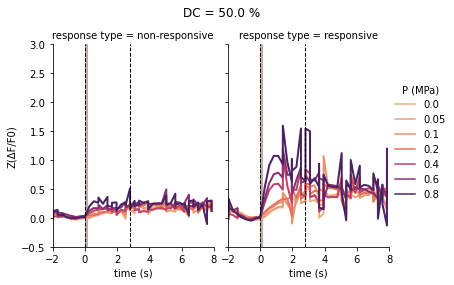

In [347]:
tracekwargs = dict(
    tbounds = [-2, 8.],  # s
    ybounds = {
        Label.ZSCORE: [-.5, 3.],
        Label.DFF: [0, .25]
        }[ykey],   # y-axis unit
    height = 4,  # height of each figure axis
    aspect = 0.7,  # width / height aspect ratio of each axis
)

# Pressure dependency
figs[f'responses {ykey} by type DC={DC_REF}%'] = plot_responses(
    avg_plt_data2, ykey=ykey, DC=DC_REF, hue=Label.P, 
    col=Label.ROI_RESP_TYPE, ci=None, **tracekwargs)
    # # Duty cycle dependency
    # figs[f'responses {ykey} by type P={P_REF}MPa'] = plot_responses(
    #     plt_data, ykey=ykey, P=P_REF, hue=Label.DC, 
    #     col=Label.ROI_RESP_TYPE, **tracekwargs)

### Save figures

In [50]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, prefix='global')

 10/05/2022 14:44:52: saving figure "rtype_dist_per_mousereg" on page 0
 10/05/2022 14:44:52: saving figure "relative Z(ΔF/F0) change vs P (MPa)" on page 1
